In [18]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score,auc

from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import cross_val_score, KFold


import numpy as np
from sklearn.linear_model import LogisticRegression




Random Forest para ver la precision del modelo

In [2]:
# Lista para almacenar los DataFrames de cada CSV
dfs = []

# Ruta de la carpeta que contiene los CSVs
carpeta_csvs = 'CSVS'

# Iterar sobre los archivos en la carpeta CSV
for archivo in os.listdir(carpeta_csvs):
    if archivo.endswith(".csv"):
        ruta_csv = os.path.join(carpeta_csvs, archivo)
        # Leer el CSV y agregarlo a la lista
        dfs.append(pd.read_csv(ruta_csv))

# Combinar todos los DataFrames en uno solo
df_combinado = pd.concat(dfs, ignore_index=True)

# Crear la columna 'resultado' basada en los goles de equipo local y visitante
df_combinado['resultado'] = df_combinado.apply(lambda row: 1 if row['goles_equipo_local'] > row['goles_equipo_visitante'] else (2 if row['goles_equipo_local'] == row['goles_equipo_visitante'] else 0), axis=1)

# Manejar NaN remplazándolos con un valor específico (por ejemplo, 0)
df_combinado.fillna(0, inplace=True)

# Separar las características (X) y la variable objetivo (y)
X = df_combinado[['goles_equipo_local', 'goles_equipo_visitante']]
y = df_combinado['resultado']

# Crear el clasificador de Bosques Aleatorios
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X, y)

# Realizar predicciones en todo el conjunto de datos
y_pred = rf_classifier.predict(X)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')


Precisión del modelo: 0.96


Vamos a visualizar gráficamente el rendimiento del modelo utilizando diversas herramientas.

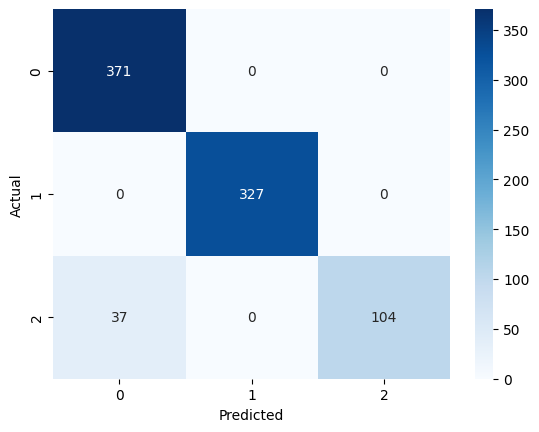

In [4]:
# Obtener predicciones del modelo
y_pred = rf_classifier.predict(X)

# Calcular la matriz de confusión
cm = confusion_matrix(y, y_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


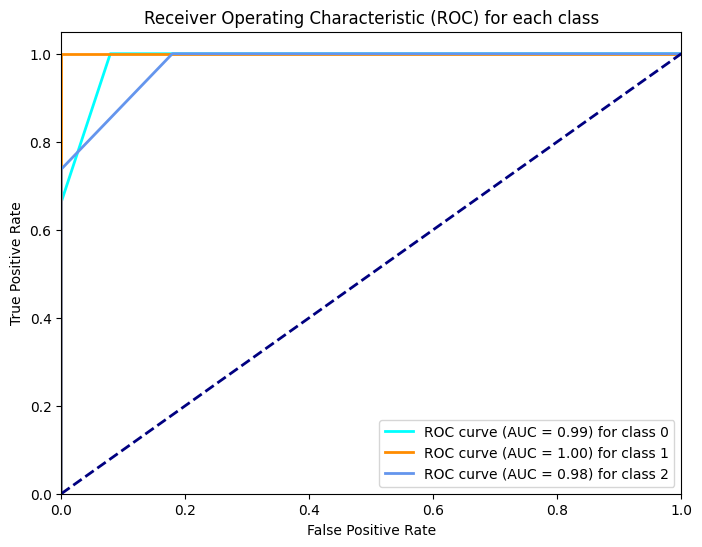

In [11]:
# Binariza las etiquetas
y_bin = label_binarize(y, classes=[0, 1, 2])  # Reemplaza [0, 1, 2] con las clases específicas en tu problema
classes = [0, 1, 2]  # Reemplaza [0, 1, 2] con las clases específicas en tu problema

# Configura el clasificador multiclase
classifier = OneVsRestClassifier(rf_classifier)

# Entrenar el modelo
classifier.fit(X, y_bin)

# Calcula las curvas ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], classifier.predict_proba(X)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Configura el gráfico
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  # Puedes ajustar los colores según tus preferencias

# Plotea las curvas ROC para cada clase
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for class {classes[i]}')

# Configuración adicional del gráfico
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for each class')
plt.legend(loc="lower right")
plt.show()

La curva ROC para cada clase muestra la capacidad del sistema para discriminar entre esa clase y la clase negativa.
Una curva ROC que se encuentra más cerca de la esquina superior izquierda indica una mejor capacidad de discriminación.
En este caso, las tres curvas ROC se encuentran cerca de la esquina superior izquierda, lo que indica una buena capacidad de discriminación para las tres clases.

Modelo de regresion

In [19]:


# Ruta de la carpeta que contiene los CSVs
carpeta_csvs = 'CSVS'

# Lista para almacenar los DataFrames
dfs = []

# Iterar sobre los archivos en la carpeta CSV
for archivo in os.listdir(carpeta_csvs):
  if archivo.endswith(".csv"):
    ruta_csv = os.path.join(carpeta_csvs, archivo)
    # Leer el CSV y agregarlo a la lista
    dfs.append(pd.read_csv(ruta_csv))

# Combinar todos los DataFrames en uno solo
df_combinado = pd.concat(dfs, ignore_index=True)

# Crear la columna 'resultado' basada en los goles de equipo local y visitante
df_combinado['resultado'] = df_combinado.apply(lambda row: 1 if row['goles_equipo_local'] > row['goles_equipo_visitante'] else (0 if row['goles_equipo_local'] == row['goles_equipo_visitante'] else 2), axis=1)

# Lidiar con los valores faltantes
df_combinado = df_combinado.fillna(method='ffill')

# Features (X) y variable dependiente (y)
X = df_combinado[['goles_equipo_local', 'goles_equipo_visitante']]
y = df_combinado['resultado']

# Verificar si el conjunto de entrenamiento es vacío
if X.shape[0] == 0:
  print("Error: No hay datos para entrenar el modelo. Revisa la eliminación de valores NaN.")
else:
  # Inicializar y entrenar el modelo de regresión logística
  regression_model = LogisticRegression()
  regression_model.fit(X, y)

  # Realizar predicciones en el conjunto de prueba
  y_pred = regression_model.predict(X)

  # Calcular la precisión del modelo
  accuracy = accuracy_score(y, y_pred)
  print(f"Precisión del modelo: {accuracy:.2f}")

Precisión del modelo: 0.63


Precision baja

Vamos a ver la precision de nuestro modelo utilizando Hiperparámetros

In [20]:
# Lidiar con los valores faltantes
df_combinado = df_combinado.fillna(method='ffill')

# Definir las variables 'features' y 'target'
features = df_combinado[['goles_equipo_local', 'goles_equipo_visitante']]
target = df_combinado['resultado']

# Definir el modelo de regresión logística
model = LogisticRegression()

# Definir el número de folds
k_folds = 5

# Evaluar el modelo usando K-Fold Cross Validation
scores = cross_val_score(model, features, target, cv=KFold(n_splits=k_folds, shuffle=True))

# Imprimir la precisión promedio
print("Precisión promedio:", scores.mean())

# Ajustar el hiperparámetro C
model = LogisticRegression(C=1.0)

# Evaluar el modelo usando K-Fold Cross Validation
scores = cross_val_score(model, features, target, cv=KFold(n_splits=k_folds, shuffle=True))

# Imprimir la precisión promedio
print("Precisión promedio con C=1.0:", scores.mean())

Precisión promedio: 0.6042343883661249
Precisión promedio con C=1.0: 0.6209366980325064


Sigue siendo baja